In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

<h2> We begin by making the algorithm for two dimensions data points in order to well understand what is going on </h2>

In [2]:
def generate_gaussian_points(num_points_per_distribution, mean_list, cov_list):
    points = []
    for mean, cov in zip(mean_list, cov_list):
        # Generate points from a Gaussian distribution with given mean and covariance
        points.extend(np.random.multivariate_normal(mean, cov, num_points_per_distribution))
    return np.array(points)

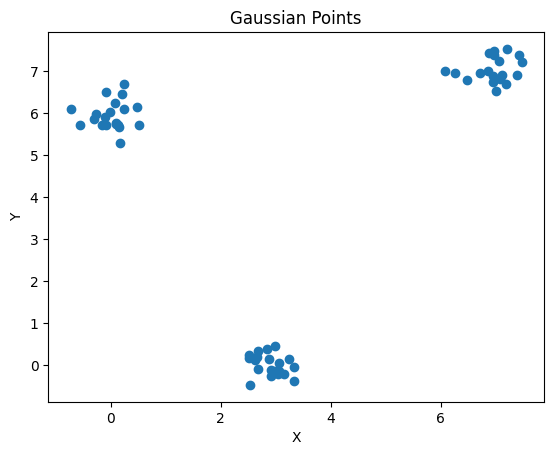

In [3]:
# Example usage:
# Set parameters
num_points_per_distribution = 20
mean_list = [[3, 0], [0, 6], [7, 7]]
cov_list = [[[.1, 0], [0, .1]], [[.1, 0], [0, .1]], [[.1, 0], [0, .1]]]

# Generate Gaussian points
points_gaussian = generate_gaussian_points(num_points_per_distribution, mean_list, cov_list)

# Plot the points
import matplotlib.pyplot as plt
plt.scatter(points_gaussian[:, 0], points_gaussian[:, 1])
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Gaussian Points')
plt.show()


In [4]:
# Function to create a dataframe with indices from 2D data points
def add_index_to_data(data): 
    df = pd.DataFrame(data, columns=['X', 'Y'])
    df['Index'] = df.index
    return df[['Index', 'X', 'Y']]

In [5]:
# Example
data_with_index = add_index_to_data(points_gaussian)
data_with_index.head()

,Index,X,Y
0,0,2.909415,-0.261801
1,1,2.507711,0.173124
2,2,2.542255,-0.472329
3,3,3.035638,-0.212502
4,4,3.325234,-0.381611


In [6]:
# Function that calculates p(x|i)
def px_i(data_point, data_point_i, s):
    proba = np.exp(-1/(2*s**2) * np.linalg.norm(data_point - data_point_i)**2 )
    return proba

In [7]:
# Function to calculate p(x|i) and p(i, x) for all points in the dataframe
def calculate_probabilities(df, s=1):
    n_data = len(df)
    px_given_i = []
    joint_pix = []
    for i in range(len(df)):
        data_point = df[['X', 'Y']].iloc[i].values
        index = df['Index'].iloc[i]
        
        # Calculate p(x|i)
        px_i_values = [px_i(data_point, data_point_i, s) for data_point_i in df[['X', 'Y']].values]
        # Normalize p(x|i) to ensure sum equals 1
        px_i_values /= np.sum(px_i_values)
        px_given_i.append(px_i_values)
        
        # Calculate p(i, x)
        pix_values = px_i_values * 1/n_data
        joint_pix.append(pix_values)
    
    px_given_i = np.array(px_given_i)
    joint_pix = np.array(joint_pix)
    return px_given_i, joint_pix


In [8]:
px_given_i, joint_pix = calculate_probabilities(data_with_index)

In [9]:
def kl_divergence(p, q):
    """
    Calculate the Kullback-Leibler divergence between two discrete probability distributions.

    Parameters:
    p (array-like): The first probability distribution.
    q (array-like): The second probability distribution.

    Returns:
    float: The KL divergence between distributions p and q.
    """
    p = np.asarray(p, dtype=float)
    q = np.asarray(q, dtype=float)
    
    # Ensure that distributions sum up to 1
    p = p / np.sum(p)
    q = q / np.sum(q)
    
    # Ignore division by zero warning when q[i] is 0
    with np.errstate(divide='ignore'):
        kl = np.sum(p * np.log(p / q))
    
    return kl

In [23]:
def iterative_algorithm(p_xy, max_iter=100, beta=0.5):
    """
    Performs the iterative algorithm for clustering.

    Parameters:
    - p_xy (numpy.ndarray): The joint probability distribution of data points and clusters.
    - max_iter (int): The maximum number of iterations for the algorithm. Default is 100.
    - beta (float): The beta parameter for the algorithm. Default is 0.5.

    Returns:
    - q_t_given_x (numpy.ndarray): The conditional probability distribution of clusters given data points.
    - q_t (numpy.ndarray): The marginal probability distribution of clusters.
    - q_y_given_t (numpy.ndarray): The conditional probability distribution of data points given clusters.
    """
    num_data_points = p_xy.shape[0]
    num_clusters = p_xy.shape[1]
    
    # Initialize f(x) as if each index i is assigned to its own cluster
    f_x = np.arange(num_data_points)
    #f_x = np.random.randint(low=0, high=1, size=num_data_points)

    # Initialization 
    d_xt = np.zeros((num_data_points, num_clusters))
    p_y_given_x = p_xy / np.sum(p_xy, axis=1, keepdims=True)
    p_x = np.sum(p_xy, axis=1)
    print("\np_x")
    print(p_x)
    
    # Initialize q(t) and q(y|t)
    q_t = np.zeros(num_clusters)
    q_y_given_t = np.zeros_like(p_xy)
    for t in range(num_clusters):
        relevant_indices = np.where(f_x == t)[0]
        if len(relevant_indices) > 0:
            q_t[t] = np.sum(p_x[relevant_indices])
            q_y_given_t[t] = np.sum(p_xy[relevant_indices], axis=0) / np.sum(p_x[relevant_indices])
    print("\np_y_given_x")
    print(p_y_given_x)
    print("\nq_y_given_t")
    print(q_y_given_t)

    
    q_t /= np.sum(q_t)  # Normalize q(t)
    print("\nq_t")
    print(q_t)
    # Iterative algorithm
    for _ in range(max_iter):
        
        # Compute d, l_beta, and f
        for i in range(num_data_points):
            for j in range(num_clusters):
                d_xt[i, j] = kl_divergence(p_y_given_x[i], q_y_given_t[j])
        print("\nd_xt")
        print(d_xt)
        l_beta_xt = np.log(q_t) - beta * d_xt
        print("\nl_beta_xt")
        print(l_beta_xt)

        f_x = np.argmax(l_beta_xt, axis=1)
        print("\nf_x")
        print(f_x)
        
        # Update q_t_given_x
        q_t_given_x = np.eye(num_clusters)[f_x]
        print("\nq_t_given_x")
        print(q_t_given_x)
        
        # Update q_t and q_y_given_t
        for t in range(num_clusters):
            relevant_indices = np.where(f_x == t)[0]
            if len(relevant_indices) > 0:
                q_t[t] = np.sum(p_x[relevant_indices])
                q_y_given_t[t] = np.sum(p_xy[relevant_indices], axis=0) / np.sum(p_x[relevant_indices])
        
        q_t /= np.sum(q_t)  # Normalize q(t)
        print("\nq_t")
        print(q_t)
        print("\nq_y_given_t")
        print(q_y_given_t)

    return q_t_given_x, q_t, q_y_given_t

data = [[0,0], [1,1], [5,5], [6.5,6.5]]
data_indexed = add_index_to_data(data)
data_px_given_i, data_joint_pix = calculate_probabilities(data_indexed)
# Run the iterative algorithm
q_t_given_x, q_t, q_y_given_t = iterative_algorithm(data_joint_pix, max_iter=10, beta = 0.1)

# Print the resulting distributions
print("\nq(t|x):")
print(q_t_given_x)
print("\nq(t):")
print(q_t)
print("\nq(y|t):")
print(q_y_given_t)


p_x
[0.25 0.25 0.25 0.25]

p_y_given_x
[[7.31058579e-01 2.68941421e-01 1.01529005e-11 3.27348471e-19]
 [2.68941399e-01 7.31058518e-01 8.22697981e-08 5.32775278e-14]
 [1.25637346e-11 1.01804996e-07 9.04650443e-01 9.53494552e-02]
 [4.05078305e-19 6.59284350e-14 9.53494649e-02 9.04650535e-01]]

q_y_given_t
[[7.31058579e-01 2.68941421e-01 1.01529005e-11 3.27348471e-19]
 [2.68941399e-01 7.31058518e-01 8.22697981e-08 5.32775278e-14]
 [1.25637346e-11 1.01804996e-07 9.04650443e-01 9.53494552e-02]
 [4.05078305e-19 6.59284350e-14 9.53494649e-02 9.04650535e-01]]

q_t
[0.25 0.25 0.25 0.25]

d_xt
[[ 0.          0.46211724 22.09753076 38.54070639]
 [ 0.46211778  0.         17.93847345 32.99529656]
 [26.64329278 17.35724531  0.          1.82092857]
 [40.60374056 28.88978904  1.82092751  0.        ]]

l_beta_xt
[[-1.38629436 -1.43250609 -3.59604744 -5.240365  ]
 [-1.43250614 -1.38629436 -3.18014171 -4.68582402]
 [-4.05062364 -3.12201889 -1.38629436 -1.56838722]
 [-5.44666842 -4.27527327 -1.56838711 -

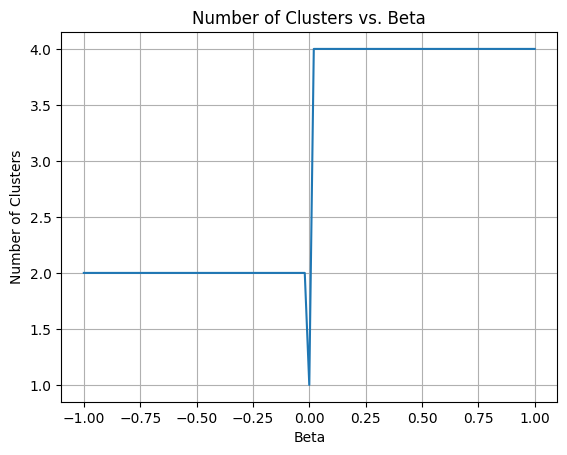

In [13]:
# Define a range of beta values
betas = np.linspace(-1, 1, 101)

# Initialize an empty list to store the number of clusters
num_clusters_list = []

# Iterate over each beta value
for beta in betas:
    # Run iterative_algorithm to obtain q_t_given_x
    q_t_given_x, _, _ = iterative_algorithm(data_joint_pix, max_iter=100, beta=beta)
    
    # Calculate the number of clusters
    column_sum = np.sum(q_t_given_x, axis=0)
    num_clusters = np.count_nonzero(column_sum)
    
    # Append the number of clusters to the list
    num_clusters_list.append(num_clusters)

# Plot the number of clusters against beta values
plt.plot(betas, num_clusters_list)
plt.xlabel('Beta')
plt.ylabel('Number of Clusters')
plt.title('Number of Clusters vs. Beta')
plt.grid(True)
plt.show()

In [14]:
joint_pix_1 = [[0.5, 0], [0, 0.5]]
joint_pix_1 = np.array(joint_pix_1)

# Run the iterative algorithm
q_t_given_x, q_t, q_y_given_t = iterative_algorithm(joint_pix_1, beta=0.5)

# Print the resulting distributions
print("q(t|x):")
print(q_t_given_x)
print("\nq(t):")
print(q_t)
print("\nq(y|t):")
print(q_y_given_t)

q(t|x):
[[1. 0.]
 [1. 0.]]

q(t):
[0.99019608 0.00980392]

q(y|t):
[[0.5 0.5]
 [0.  1. ]]


/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_24089/2819231164.py:21: RuntimeWarning: invalid value encountered in divide
  kl = np.sum(p * np.log(p / q))
/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_24089/2819231164.py:21: RuntimeWarning: invalid value encountered in multiply
  kl = np.sum(p * np.log(p / q))


In [15]:
# Run the iterative algorithm
q_t_given_x, q_t, q_y_given_t = iterative_algorithm(joint_pix, max_iter=100, beta = 0)

# Print the resulting distributions
print("q(t|x):")
print(q_t_given_x)
print("\nq(t):")
print(q_t)
print("\nq(y|t):")
print(q_y_given_t)

q(t|x):
[[0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]

q(t):
[1.67785235e-04 9.90100671e-01 1.67785235e-04 1.67785235e-04
 1.67785235e-04 1.67785235e-04 1.67785235e-04 1.67785235e-04
 1.67785235e-04 1.67785235e-04 1.67785235e-04 1.67785235e-04
 1.67785235e-04 1.67785235e-04 1.67785235e-04 1.67785235e-04
 1.67785235e-04 1.67785235e-04 1.67785235e-04 1.67785235e-04
 1.67785235e-04 1.67785235e-04 1.67785235e-04 1.67785235e-04
 1.67785235e-04 1.67785235e-04 1.67785235e-04 1.67785235e-04
 1.67785235e-04 1.67785235e-04 1.67785235e-04 1.67785235e-04
 1.67785235e-04 1.67785235e-04 1.67785235e-04 1.67785235e-04
 1.67785235e-04 1.67785235e-04 1.67785235e-04 1.67785235e-04
 1.67785235e-04 1.67785235e-04 1.67785235e-04 1.67785235e-04
 1.67785235e-04 1.67785235e-04 1.67785235e-04 1.67785235e-04
 1.67785235e-04 1.67785235e-04 1.67785235e-04 1.67785235e-04
 1.67785235e-04 1.67785235e-04 1.677

In [16]:
column_sum = np.sum(q_t_given_x, axis=0)
num_clusters = np.count_nonzero(column_sum)

print("Number of clusters:", num_clusters)

Number of clusters: 1


In [17]:
def plot_clusters(data_points, q_t_given_x):
    """
    Plot the data points and color them based on the cluster they are associated with.

    Parameters:
        data_points (numpy.ndarray): Array of data points with shape (n_samples, n_features).
        q_t_given_x (numpy.ndarray): Probability distribution over clusters given data points, 
                                      with shape (n_samples, n_clusters).

    Returns:
        None
    """
    # Determine the cluster assignment for each data point based on q(t given x)
    cluster_assignments = np.argmax(q_t_given_x, axis=1)
    
    # Define a color map for visualizing clusters
    colors = plt.cm.tab10(cluster_assignments / max(cluster_assignments))

    # Plot the data points with colors based on clusters
    plt.scatter(data_points[:, 0], data_points[:, 1], c=colors, alpha=0.7)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Data Points Colored by Clusters')
    plt.show()


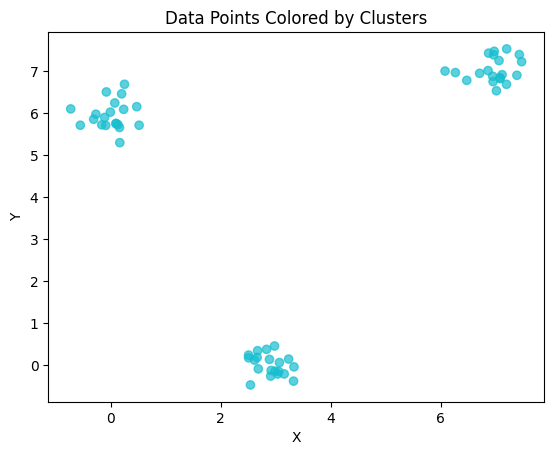

In [18]:
plot_clusters(points_gaussian, q_t_given_x)

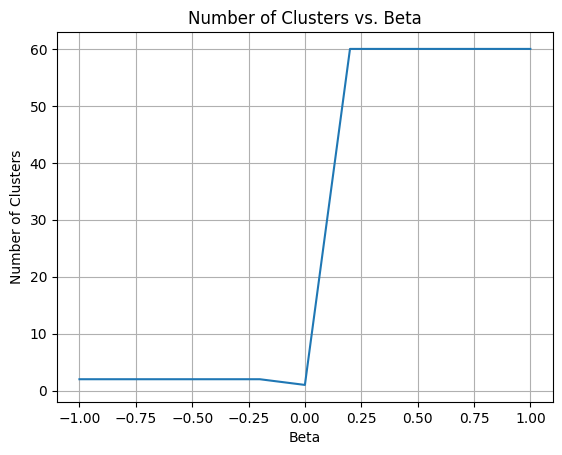

In [19]:
# Define a range of beta values
betas = np.linspace(-1, 1, 11)

# Initialize an empty list to store the number of clusters
num_clusters_list = []

# Iterate over each beta value
for beta in betas:
    # Run iterative_algorithm to obtain q_t_given_x
    q_t_given_x, _, _ = iterative_algorithm(joint_pix, max_iter=100, beta=beta)
    
    # Calculate the number of clusters
    column_sum = np.sum(q_t_given_x, axis=0)
    num_clusters = np.count_nonzero(column_sum)
    
    # Append the number of clusters to the list
    num_clusters_list.append(num_clusters)

# Plot the number of clusters against beta values
plt.plot(betas, num_clusters_list)
plt.xlabel('Beta')
plt.ylabel('Number of Clusters')
plt.title('Number of Clusters vs. Beta')
plt.grid(True)
plt.show()


<h2> Maybe useful later </h2>

<h2> From data points, we have a function that gives p(x,y), p(y|x) and p(x). We can now begin the information bottleneck algorithm. </h2> 

In [20]:
def compute_distributions(points, bins):
    # Compute joint distribution p(x,y) by slicing the plane into nxn bins
    joint_distribution, _ = np.histogramdd(points, bins, density=True)
    
    # Compute marginal distribution p(x)
    marginal_distribution_x = np.sum(joint_distribution, axis=1)
    
    # Compute conditional distribution p(y|x)
    conditional_distribution_y_given_x = joint_distribution / marginal_distribution_x[:, np.newaxis]
    
    return joint_distribution, marginal_distribution_x, conditional_distribution_y_given_x

In [21]:
# Compute distributions
joint_distribution, marginal_distribution_x, conditional_distribution_y_given_x = compute_distributions(points_gaussian, bins = 20)

# Print or use the distributions as needed
print("Joint distribution p(x,y):")
print(joint_distribution)
print("\nMarginal distribution p(x):")
print(marginal_distribution_x)
print("\nConditional distribution p(y|x):")
print(conditional_distribution_y_given_x)


Joint distribution p(x,y):
[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.10157596 0.10157596 0.
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.40630384 0.30472788 0.10157596
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.10157596 0.40630384 0.20315192 0.20315192
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.10157596 0.         0.
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.  

/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_24089/3440602990.py:9: RuntimeWarning: invalid value encountered in divide
  conditional_distribution_y_given_x = joint_distribution / marginal_distribution_x[:, np.newaxis]
